# __Classifying classical and vernacular Chinese text with a random forest__

### Our goal is to create a classifier that can distinguish between classical and vernacular Chinese, given a labeled dataset.
 - We will use a labeled training set with sentences written in either classical or vernacular Chinese, and another unlabeled set. 
 - Sentences in classical Chinese are taken from works such as the _Records of the Grand Historian_ and _Liaozhai Zhiyi_, and those in vernacular Chinese are taken from 'modern,' annotated versions of those works.


#### First we need to load our data:

In [1]:
import numpy as np
import pandas as pd

train_set = pd.read_csv('./data/train.txt')
unlabeled_set = pd.read_csv('./data/test.txt')

train_set.head(10)

,id,text,y
0,0,来扰乱天子的边防,0
1,1,崤山以东地区虽然混乱,0
2,2,秦昭王闻之 使人遗赵王书 愿以十五城请易璧,1
3,3,臣不胜受恩感激,1
4,4,现在如果把东西寄存在别人处,0
5,5,南北朝所以不治 文采胜质厚也,1
6,6,而流贼进攻更急 城里有许多不同的意见,0
7,7,吾上有三兄 皆不幸早世,1
8,8,没有人不讲究熏衣剃面,0
9,9,王曰 善,1


#### Let's split our data into vernacular and classical subsets to visualize everything easier.

In [2]:
# Get rid of 'id' column
train_set.drop('id', axis=1, inplace=True)
unlabeled_set.drop('id', axis=1, inplace=True)

# Per literary tradition, the task of adding breaks and pauses while reading a text is the responsibility of the reader;
# We should probably remove any spaces in our file, lest our model trains itself to recognize spaces as indicators of classical/vernacular Chinese.

train_set['text'] = train_set['text'].str.replace(' ', '')
unlabeled_set['text'] = unlabeled_set['text'].str.replace(' ', '')

In [3]:
ind_vernacular = train_set['y'] == 0
ind_classical  = train_set['y'] == 1

vernacular = train_set[ind_vernacular]
classical  = train_set[ind_classical]

#### Taking a look at the most common characters in each subset:

In [4]:
from collections import Counter

st_names, ind = ['vernacular', 'classical'], 0
for st in [vernacular, classical]:
    cnt = Counter()
    
    for inst in range(len(st)):
        ln = st.iloc[inst, 0]
        
        for char in ln:
            cnt[char] += 1
            
        com = cnt.most_common(10)
        
    print('Most common', st_names[ind], 'characters:')
    
    for i, c in enumerate(com):
        print(str(i+1)+'.', c[0]+':', c[1], 'instances')
        
    print()
    ind += 1

Most common vernacular characters:
1. 的: 1287 instances
2. 不: 508 instances
3. 人: 429 instances
4. 是: 396 instances
5. 了: 390 instances
6. 有: 385 instances
7. 一: 338 instances
8. 来: 271 instances
9. 他: 268 instances
10. 我: 266 instances

Most common classical characters:
1. 之: 1265 instances
2. 不: 703 instances
3. 而: 586 instances
4. 以: 516 instances
5. 也: 453 instances
6. 其: 433 instances
7. 为: 404 instances
8. 者: 378 instances
9. 人: 374 instances
10. 于: 321 instances



#### This looks very reasonable! Now we can vectorize the sentences and create a model:

In [5]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=train_set['text']) # Leaving other parameters as default

#### To make sure our model works correctly, we can query some characters and ask it to return the most 'similar' characters.
#### For instance, if we query 「矣」 we should expect to get a list of other common characters used in classical Chinese (with respect to our data, at least), since we know that 「矣」 appears in classical Chinese much more often than it does in vernacular.
#### On the other hand, if we query 「天」 we should expect to get a list of characters that we can expect to see in both vernacular and classical Chinese, since we know that 「天」 shows up more or less frequently in both.

In [6]:
chars_list = [['矣'], model.wv.most_similar('矣', topn=10), ['天'], model.wv.most_similar('天', topn=10)]

for chars in chars_list:
    out = ''
    
    for char in chars:
        out += char[0]
    print(out)
    
    if len(char) != 1:
        print()

矣
则而乃欲衣民故言为于

天
风云法着及游非城孙往



#### Now we have to vectorize our feature matrix:

In [7]:
m = len(train_set) + len(unlabeled_set)
dims = 100

vector = np.zeros([m, dims])

text = list(train_set['text']) + list(unlabeled_set['text'])
for ind, ln in enumerate(text):
    cnts, row = 0, 0
    
    for char in ln:
        try:
            row += model.wv[char]
            cnts += 1
            
        except:
            pass
        
    vector[ind, :] = row / cnts

#### Splitting vectorized feature matrix into training and testing subsets:

In [8]:
from sklearn.model_selection import train_test_split
A = vector[:len(train_set)]
B = np.transpose(np.array([train_set['y']]))

vectorized_mat = np.concatenate([A, B], axis=1)
n = len(vectorized_mat[0])

X = vectorized_mat[:,:n-1]
y = vectorized_mat[:,n-1]

X_unlabeled = vector[len(train_set):]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Let's try to use a random forest to classify our data. 

#### Since we don't know what the maximum depth of each decision tree should be, we can try a range of values to find a balance between having an accurate model and overfitting the data.

In [9]:
from sklearn.ensemble import RandomForestClassifier

train_acc = []
test_acc = []

# Try changing the max_depth in the RandomForestClassifier
# and recording the training and testing accuracies

depth = range(3, 11)
for n_depth in depth:
    forest = RandomForestClassifier(n_estimators=100, max_depth=n_depth, n_jobs=-1, random_state=0)
    forest.fit(X_train, y_train)
    
    train_acc.append(forest.score(X_train, y_train))
    test_acc.append(forest.score(X_test, y_test))

#### Hopefully we can gain some insight from plotting the training and testing accuracies.

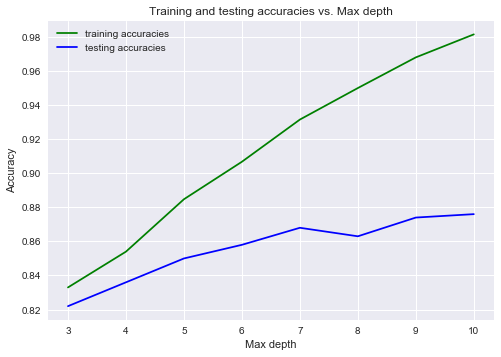

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('seaborn')

plt.title('Training and testing accuracies vs. Max depth')
plt.plot(
         depth, 
         train_acc, 
         label='training accuracies', 
         color='green'
)
plt.plot(
         depth, 
         test_acc, 
         label='testing accuracies', 
         color='blue'
)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### A max depth of 7 looks pretty good, so we can make a new model based on that:

In [11]:
forest = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=-1, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### We can now take the unlabeled data from before and make predictions:

In [12]:
pred = forest.predict(X_unlabeled)
pred = pd.DataFrame(pred, columns=['prediction'])

pred.replace(to_replace=0.0, value='vernacular', inplace=True)
pred.replace(to_replace=1.0, value='classical', inplace=True)

final = pd.concat([unlabeled_set, pred], axis=1)
final.head()

,text,prediction
0,后来又合并为七个强国,vernacular
1,与吾父居者今其室十无二三焉,classical
2,那么政局就会安定了,vernacular
3,我资米若薪于百姓后之人必尔乎索之,classical
4,昔虞国宫之奇少长於君君狎之,classical


#### Judging from the first five sentences in the unlabeled dataset, it looks like our classifier is working very well - there doesn't seem to be anything wrong here. We should revisit the labeled data from earlier and see where our classifier makes a mistake.

In [13]:
X_train_predict = forest.predict(X_train)
errors = X_train_predict != y_train
error_lines = X_train[errors]

#### Our strategy is just to pick several mistakenly classified sentences and print them out.

In [14]:
for i in range(5):
    for ind in range(0, len(vector)):
        if np.array_equal(error_lines[i], vector[ind]):
            if train_set.iloc[ind,1] == 0:
                print('Actual: Vernacular')
            else:
                print('Actual: Classical')
            print(train_set.iloc[ind,0])
            print()

Actual: Classical
北定中原庶竭驽钝攘除奸凶兴复汉室还于旧都

Actual: Vernacular
年成丰收而您的夫人却仍为食粮不足而啼说饥饿

Actual: Vernacular
武夫则练习骑马射箭文士则研究议论经书

Actual: Classical
玉斗一双再拜奉大将军足下

Actual: Vernacular
傅玄因愤争而免官



#### The mistakes seem generally understandable - the second and fourth lines in particular are written quite ambiguously. It's likely that people without prior exposure to classical Chinese would have made similar errors.